### Libraries

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline

from scipy.spatial.distance import mahalanobis
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # TODO 

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV #TODO
from sklearn.linear_model import LinearRegression # TODO
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR #TODO

### Set random seed

In [2]:
# set the random state
random_state = min(332078,332464)
np.random.seed(random_state)

### Dataset

In [74]:
df_dev = pd.read_csv('development.csv')

In [ ]:
# shape
df_dev.shape

In [ ]:
# columns
df_dev.columns

1) x, y: the position of the events over the sensor
2) pmax[0], pmax[1], ... pmax[17]: the magnitude of the positive peak of the signal, in mV
3) negpmax[0], negpmax[1], ... negpmax[17]: the magnitude of the negative peak of the signal, in mV
4) tmax[0], tmax[1], ... tmax[17]: the delay (in ns) from a reference time when the positive peak of the signal
5) area[0], area[1], ... area[17]: the area under the signal
6) rms[0], rms[1], ... rms[17]: the root mean square (RMS) value of the signal

In [ ]:
# NaN values
display(df_dev.isna().any())
print(f'\nThe dataset has {df_dev.isna().any().sum()} NaN values')

# Preprocessing

### Data visualization

In [ ]:
# scatter plot of x and y

mpl.rcParams["font.size"] = 14

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(df_dev['x'], df_dev['y'], s=20, alpha=0.5, marker='8')
ax.set_title('Events coordinates')
ax.set_xlabel('$X$ ($\\mu m$)')
ax.set_ylabel('$Y$ ($\\mu m$)')

plt.show()

fig.savefig("events.png", bbox_inches="tight")

Some areas of the sensor are not covered by any event. That occurs because, at those coordinates, either pads or wires used to read the signals from the pads (due to their reflective properties) are presen

In [ ]:
# plot of the features
mpl.rcParams["font.size"] = 14

for elem in ['pmax','negpmax','area','tmax','rms']:
    rows, cols = 6, 3
    fig, ax = plt.subplots(rows, cols, figsize=(25, 20))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    i=0
    for row in range(rows):
        for col in range(cols):
            ax[row, col].plot(df_dev[f'{elem}[{i}]'])
            ax[row,col].set_title(f'{elem}[{i}]')
            ax[row,col].set_xlabel('events')
            ax[row,col].set_ylabel('magnitude')
            i+=1
    plt.show()
    print()

In [ ]:
# sensor position with respect to the pmax feature
mpl.rcParams["font.size"] = 14

elem = 'pmax'
rows, cols = 5, 4
fig, ax = plt.subplots(rows, cols, figsize=(25, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i=0

for row in range(rows):
    for col in range(cols):
        if i < 18:
            limit = df_dev[f'{elem}[{i}]'].mean() + 2*df_dev[f'{elem}[{i}]'].std()
            mask = df_dev[f'{elem}[{i}]'] > limit
            ax[row, col].scatter(df_dev['x'],df_dev['y'], s=15, alpha=0.5)
            ax[row, col].scatter(df_dev[mask]['x'],df_dev[mask]['y'],c='orange', s=15)
            ax[row,col].set_title(f'Pad {i}')
            ax[row,col].set_xlabel('$X$ ($\\mu m$)')
            ax[row,col].set_ylabel('$Y$ ($\\mu m$)')
            ax[row, col].set_xlim(200, 600)
            ax[row, col].set_ylim(200, 600)
        i+=1
# remove empty subplots
fig.delaxes(ax[4, 2])
fig.delaxes(ax[4, 3])

fig.legend(labels=['All events', 'Above limit'],fontsize='x-large', bbox_to_anchor=[0.9, 0.2])
plt.show()
fig.savefig("pmax.png", bbox_inches="tight")

### Remove noise features

Thanks to the previous graph, we can deduce that the noise is caused by features: 0, 7, 12, 15, 16, and 17. As for feature 15, it was not easy to determine whether it was actually a source of noise. However, thanks to the last graph, we can see that the alleged pad 15 is able to detect high peaks on distant sensor areas. This implies that it does indeed constitute a source of noise.

In [75]:
# list of feature indices with noise
noise_features = [0,7,12,15,16,17]
# list of feature indices without noise
no_noise_features = [elem for elem in np.arange(18) if elem not in noise_features]

In [76]:
# remove noise features
for i in noise_features:
   df_dev = df_dev.drop(columns=[f'pmax[{i}]',f'negpmax[{i}]',f'area[{i}]',f'tmax[{i}]',f'rms[{i}]'])

### Outlier detection

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
mpl.rcParams["font.size"] = 14
# first row
for idx, elem in enumerate(['pmax', 'negpmax']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[0, idx])
    ax[0, idx].set_xticklabels(ax[0, idx].get_xticklabels(), rotation=75)
    ax[0, idx].set_ylabel('Magnitude ($mV$)')

# second row
for idx, elem in enumerate(['area', 'tmax']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[1, idx])
    ax[1, idx].set_xticklabels(ax[1, idx].get_xticklabels(), rotation=75)
    if elem == 'area' :
        ax[1, idx].set_ylabel('Area')
    else:
        ax[1, idx].set_ylabel('Time ($ns$)')

# third row
for idx, elem in enumerate(['rms']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[2, idx])
    ax[2, idx].set_xticklabels(ax[2, idx].get_xticklabels(), rotation=75)
    ax[2, idx].set_ylabel('RMS value')

# remove empty subplot in the third row
fig.delaxes(ax[2, -1])

plt.tight_layout()
plt.show()
fig.savefig("boxplots.png", bbox_inches="tight")

In [77]:
# remove positive negpmax values
print('Number of lines before removing positive values from negpmax:', df_dev.shape[0])

for i in no_noise_features:
    df_dev = df_dev[df_dev[f'negpmax[{i}]'] < 0]
print('Number of lines after removing positive values from negpmax:', df_dev.shape[0])

Number of lines before removing positive values from negpmax: 385500
Number of lines after removing positive values from negpmax: 385497


In [ ]:
# TRY
for i in no_noise_features:
    df_dev = df_dev.drop(df_dev[df_dev[f'negpmax[{i}]']<-100].index)

In [ ]:
df_no_outliers = df_dev

In [ ]:
from scipy.stats import zscore
z_scores = zscore(df_dev[df_dev.drop(columns=['x','y']).columns])

# Imposta una soglia per definire gli outlier (ad esempio, 3 deviazioni standard)
threshold = 30

# Trova gli indici degli outlier
outlier_indices = (z_scores > threshold).any(axis=1)

print(outlier_indices.sum())
# Rimuovi gli outlier dal DataFrame
df_no_outliers = df_dev[~outlier_indices]

##### ZSCORE OVER SEPARATE SENSORS

In [78]:
df_no_outliers = df_dev.copy()

for i in no_noise_features:
    list_values = []
    for elem in ['pmax','negpmax','area','tmax','rms']:
        values = df_no_outliers[[f'{elem}[{i}]']].values
        list_values.append((values - values.mean()) / values.std())
    df_no_outliers[f'zscore[{i}]'] = np.array(list_values).mean(axis=0)

In [79]:
zscores = [col for col in df_no_outliers.columns if col.startswith('zscor')]

In [80]:
from collections import Counter
def get_index_zscore(df, threshold):
    return df[(df > threshold) | (df < -threshold)].index

threshold = 0.25
index_dict = {f'index_s{i}zscore': get_index_zscore(df_no_outliers[f'zscore[{i}]'], threshold) for i in no_noise_features}

index_list_zscore = np.concatenate([index for _, index in index_dict.items()])
sensor_counter = Counter(index_list_zscore)
index_to_remove = [key for key, count in sensor_counter.items() if count == 12]

last_dim = df_no_outliers.shape[0]
df_no_outliers = df_no_outliers.drop(index_to_remove).drop(columns=zscores)

print(f'Non-outlier observations: {df_no_outliers.shape[0]}')
print(f'Identified outliers: {last_dim - df_no_outliers.shape[0]}')
print()

Non-outlier observations: 385282
Identified outliers: 215



##### MAHALANOBIS DISTANCE 

In [40]:
df_no_outliers = pd.DataFrame(df_dev)

# calculate mean and inverse covariance matrix
mean = df_no_outliers.drop(columns=['x','y']).mean()

covariance_matrix = df_no_outliers.drop(columns=['x','y']).cov()

cov_inv = pd.DataFrame(np.linalg.inv(covariance_matrix.values), 
                       columns = df_no_outliers.drop(columns=['x','y']).columns, 
                       index = df_no_outliers.drop(columns=['x','y']).columns)
# calculate Mahalanobis distance for each data point
df_no_outliers['mahalanobis_distance'] = df_no_outliers.drop(columns=['x','y']).apply(lambda x: mahalanobis(x, mean, cov_inv), axis=1)

In [41]:
threshold = df_no_outliers['mahalanobis_distance'].mean() +  7 * df_no_outliers['mahalanobis_distance'].std()

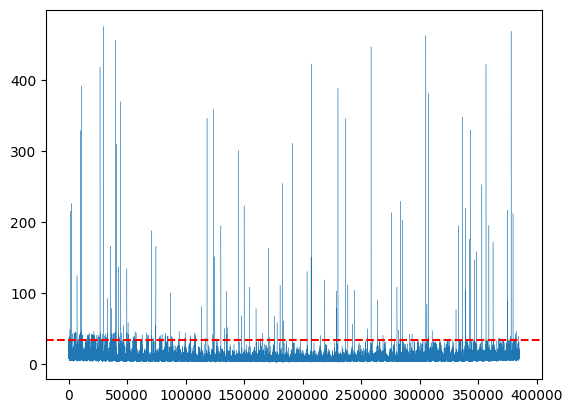

In [42]:
# plot the mahalanobis_distance over the events
df_no_outliers['mahalanobis_distance'].plot(linewidth=0.25, label='Mahalanobis Distance')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.show()

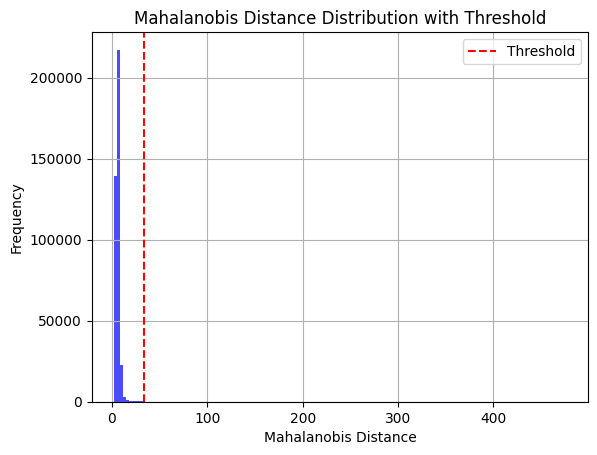

In [43]:
# plot the Mahalanobis Distance distribution
plt.hist(df_no_outliers['mahalanobis_distance'], bins=150, color='blue', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')

# Set title and labels
plt.title('Mahalanobis Distance Distribution with Threshold')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

plt.legend()
plt.grid(True)
plt.show()

In [44]:
df_no_outliers = df_no_outliers[df_no_outliers['mahalanobis_distance'] < threshold]

In [45]:
385497 - df_no_outliers.shape[0] 

251

In [46]:
df_no_outliers = df_no_outliers.drop(columns='mahalanobis_distance')

##### ZSCORE OUTLIER

In [ ]:
df_no_outliers = pd.DataFrame(df_dev)

n_outliers = 0
for elem in ['pmax','negpmax','area','tmax','rms']:
    for i in no_noise_features:
        values = df_no_outliers[[f'{elem}[{i}]']]
        df_no_outliers['zscore'] = (values - values.mean()) / values.std()

        l=15
        
        outliers = df_no_outliers[(df_no_outliers['zscore']< -l) | (df_no_outliers['zscore']> l)]
        n_outliers += len(outliers)
        
        df_no_outliers = df_no_outliers[(df_no_outliers['zscore'] >= -l) & (df_no_outliers['zscore']<= l)]
        
df_no_outliers = df_no_outliers.drop(columns=['zscore'])
print('Non-outlier observations: %d' % len(df_no_outliers))
print('Identified outliers: %d' % n_outliers)
print()

In [ ]:
df_no_outliers.shape

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# Boxplots for the first row
for idx, elem in enumerate(['pmax', 'negpmax']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[0, idx])
    ax[0, idx].set_xticklabels(ax[0, idx].get_xticklabels(), rotation=75)
    ax[0, idx].set_title(elem)

# Boxplots for the second row
for idx, elem in enumerate(['area', 'tmax']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[1, idx])
    ax[1, idx].set_xticklabels(ax[1, idx].get_xticklabels(), rotation=75)
    ax[1, idx].set_title(elem)

# Boxplots for the third row
for idx, elem in enumerate(['rms']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[2, idx])
    ax[2, idx].set_xticklabels(ax[2, idx].get_xticklabels(), rotation=75)
    ax[2, idx].set_title(elem)

# Remove empty subplot in the third row
fig.delaxes(ax[2, -1])

plt.tight_layout()
plt.show()

### Features selection

In [10]:
# train test split
X = df_no_outliers.drop(columns=['x', 'y']).values
y = df_no_outliers[['x', 'y']].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, shuffle=True, random_state=random_state)

In [11]:
# Random Forest x feature selection
reg = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)

In [12]:
# start timer
start_time = time.time()

# fit the model
reg.fit(X_train , y_train)

# end timer
end_time = time.time()
print(f'Execution Time: {end_time - start_time} seconds')

Execution Time: 277.3626139163971 seconds


In [13]:
# R2 score
print('R^2 score:',r2_score(y_valid, reg.predict(X_valid)))

R^2 score: 0.9988994232757407


In [14]:
# feature importances
feature_names = df_no_outliers.drop(columns=['x', 'y']).columns

feature_importances_list = sorted(zip(feature_names, reg.feature_importances_), key = lambda x: x[1], reverse = True)
feature_importances_list

[('pmax[8]', 0.3591889738091274),
 ('pmax[11]', 0.24136899395717942),
 ('pmax[10]', 0.1620001255777815),
 ('pmax[5]', 0.08236737250142048),
 ('pmax[13]', 0.03614042327850841),
 ('negpmax[13]', 0.026386594920993704),
 ('pmax[9]', 0.020313572570411966),
 ('negpmax[11]', 0.01295543222225327),
 ('negpmax[3]', 0.010723041253499979),
 ('negpmax[10]', 0.008354848633531647),
 ('pmax[4]', 0.006055238002272446),
 ('negpmax[8]', 0.005184902945205895),
 ('negpmax[5]', 0.004769163216076515),
 ('negpmax[1]', 0.00443758714129197),
 ('pmax[3]', 0.004436824086764246),
 ('negpmax[6]', 0.0030137190465352433),
 ('negpmax[14]', 0.0020486558173166097),
 ('pmax[2]', 0.00201319760418514),
 ('negpmax[4]', 0.0018954690604001175),
 ('pmax[1]', 0.0014106065362425358),
 ('pmax[6]', 0.0013401171158998449),
 ('negpmax[9]', 0.0012624848309441925),
 ('pmax[14]', 0.0009738732032984215),
 ('area[3]', 0.0002028077804498031),
 ('negpmax[2]', 0.0001774309533166265),
 ('area[5]', 0.00016098708513550032),
 ('area[13]', 0.000

In [ ]:
# plot the feature importances

# extract feature names and importances from the list
feature_names, importances = zip(*feature_importances_list)
mpl.rcParams["font.size"] = 14
# Plotting the vertical bar chart
plt.figure(figsize=(20, 5))
plt.bar(feature_names, importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Importance of features')
plt.xticks(rotation=75, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

As indicated by the importance given to the different features, it is evident that the worst categories are represented by tmax, rms, and area. Therefore, we will proceed with the removal of these features in order to reduce the size of the dataset.

In [81]:
# TRY 1 (best)
for i in no_noise_features:
    df_no_outliers = df_no_outliers.drop(columns=[f'tmax[{i}]',f'rms[{i}]'])

In [47]:
# TRY 2 
feature_30 = feature_importances_list[-30:]
df_no_outliers = df_no_outliers.drop(columns=[feature_30[i][0] for i in range(len(feature_30))])

In [16]:
df_no_outliers

,x,y,pmax[1],negpmax[1],pmax[2],negpmax[2],pmax[3],negpmax[3],area[3],pmax[4],...,area[10],pmax[11],negpmax[11],area[11],pmax[13],negpmax[13],area[13],pmax[14],negpmax[14],area[14]
0,200.0,200.0,5.409161,-17.721210,6.084506,-19.892543,3.811328,-23.747293,3.621973,4.893027,...,23.152819,12.438458,-18.148151,7.611376,7.454877,-16.861163,4.191909,6.611877,-17.685799,4.884680
1,200.0,200.0,4.414289,-4.736827,4.507257,-3.787175,3.940369,-5.427002,3.444678,5.549379,...,20.574321,12.326212,-5.670920,8.025536,18.472514,-3.372324,16.620582,13.802252,-5.154840,8.758870
2,200.0,200.0,4.567191,-5.985437,5.384155,-3.948853,4.903412,-4.559235,1.223700,3.795407,...,19.456946,9.253250,-4.282883,4.517316,7.336668,-5.742383,11.792258,5.940039,-3.860550,5.340140
3,200.0,200.0,5.019058,-4.229949,4.165598,-5.576041,3.791672,-4.981216,2.985681,4.848719,...,20.897897,10.900876,-5.595096,5.927390,8.450671,-6.342114,4.496741,6.434910,-5.576315,15.789638
4,200.0,200.0,3.250262,-5.783587,4.736023,-5.137939,5.123048,-4.447104,4.377708,3.026709,...,21.795638,13.956659,-5.728705,7.386077,8.721952,-4.396436,9.127136,4.483080,-5.361823,3.366542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385495,600.0,595.0,49.819376,-26.266623,55.651440,-29.947864,63.119604,-36.910852,32.034504,11.942999,...,1.715207,5.526794,-6.992345,1.990222,19.454065,-7.531409,10.650762,5.842563,-4.147369,4.551567
385496,600.0,595.0,51.016495,-26.138474,58.084024,-34.662131,59.971158,-37.721255,32.350015,11.555255,...,8.123401,15.208563,-5.161127,11.758268,17.604636,-5.505725,12.827195,11.819031,-5.125480,4.505713
385497,600.0,595.0,46.661682,-30.943115,61.840103,-35.670273,73.850089,-38.344370,33.456961,16.884897,...,9.381399,5.343299,-4.516763,4.862441,20.783524,-6.318405,13.981320,10.120659,-3.479907,11.049597
385498,600.0,595.0,46.515765,-22.520367,49.772070,-33.298181,59.277927,-36.103391,31.008201,12.191660,...,8.463049,13.605057,-5.050461,9.017706,14.048267,-6.915601,11.846003,10.754880,-5.030399,7.560762


In [ ]:
# removing tmax, area and rms feature
for i in no_noise_features:
    df_no_outliers = df_no_outliers.drop(columns=[f'tmax[{i}]',f'rms[{i}]', f'area[{i}]'])

In [82]:
# rename the dataset
df_clean = df_no_outliers

# Model implementation

In [83]:
# Train test splitting
X = df_clean.drop(columns=['x', 'y']).values
y = df_clean[['x', 'y']].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, shuffle=True, random_state=random_state)

In [ ]:
# Train test scale and splitting 

# standard scaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled = train_test_split(X_scaled, y, test_size= 0.2, shuffle=True, random_state=random_state)

### Random Forest

In [57]:
# set the params
param_grid = {
    #'n_estimators': [i for i in range(800,1100,100)],
    #'criterion': ['squared_error'],
    #'max_features': ['sqrt'],
    #'random_state': [random_state],
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, 40 ,50, None],
    'min_samples_split': [2, 4 ,5 ,8 ,10],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'bootstrap': [False],
    "random_state": [random_state],
    'verbose':[1],
    "n_jobs": [-1]
}

gs = GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', n_jobs=-1, cv=5)

gs.fit(X_train, y_train)

print(f'GridSearchCV best params: {gs.best_params_}')

######## [i for i in range(100,500,100)] ################################
# Execution Time: 1421.2425608634949 seconds 
# GridSearchCV best params: {'criterion': 'squared_error', 
#                            'max_features': 'sqrt', 
#                            'n_estimators': 400, 
#                            'random_state': 332078}
#
#                      ------- score: 4.918 -------
#
##########################################################################

######## [i for i in range(500,800,100)] ################################
#Execution Time: 2413.7543437480927 seconds
# GridSearchCV best params: {'criterion': 'squared_error', 
#                            'max_features': 'sqrt', 
#                            'n_estimators': 700, 
#                            'random_state': 332078}
#
#                      ------- score: 4.903 -------
#
##########################################################################

######## [i for i in range(800,1100,100)] ################################
# GridSearchCV best params: {'criterion': 'squared_error', 
#                            'max_features': 'sqrt', 
#                            'n_estimators': 1000, 
#                            'random_state': 332078}
#
#                      ------- score: 4.899 -------
#
##########################################################################

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks     

GridSearchCV best params: {'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 332078, 'verbose': 1}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.4s finished


In [ ]:
{'bootstrap': False, 
 'max_depth': 40, 
 'max_features': 'sqrt', 
 'min_samples_leaf': 2, 
 'min_samples_split': 2, 
 'n_estimators': 100, 
 'n_jobs': -1, 
 'random_state': 332078, 
 'verbose': 1}

In [84]:
# TRY
reg = RandomForestRegressor(n_estimators= 500, 
                            criterion='squared_error',
                            bootstrap= False, 
                            max_depth= 40, 
                            max_features= 'sqrt', 
                            min_samples_leaf= 2, 
                            min_samples_split= 2,
                            n_jobs= -1, 
                            random_state= random_state, 
                            verbose= 1)

reg.fit(X_train , y_train)

# predict
y_pred = reg.predict(X_valid)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    3.5s finished


In [ ]:
reg = RandomForestRegressor(n_estimators=100, 
                            criterion='squared_error', 
                            max_features='sqrt', 
                            random_state=random_state)

#start training
start_time = time.time()

reg.fit(X_train , y_train)

#end training
end_time = time.time()
print(f'Execution Time: {end_time - start_time} seconds')

# predict
y_pred = reg.predict(X_valid)

In [58]:
# predict
reg = gs.best_estimator_
# predict
y_pred = reg.predict(X_valid)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


### KNN

In [ ]:
# chose the best weights and algorithm
param_grid = {'n_neighbors': [i for i in range(5,50,5)],
              'weights': ['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree', 'kd_tree'],
             }


gs = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

#start training 
start_time = time.time()

gs.fit(X_train, y_train)

#end training
end_time = time.time()

print(f'Execution Time: {end_time - start_time} seconds')
print(f'GridSearchCV best params: {gs.best_params_}')

In [ ]:
# pick the best model
kkn = gs.best_estimator_

In [ ]:
# make the local prediction
y_pred = kkn.predict(X_valid)

After applying grid search on the model we saw that the best model parameters are: {}.

With this model we obtained a score, considering the Euclidean distance, of 5.573, which is worse than that obtained with the RandomForestRegressor

### SVR

In [ ]:
# SVR model
svr = SVR()

# Multi output wrapper
multi_svr = MultiOutputRegressor(svr)

#start
start_time = time.time()

multi_svr.fit(X_train_scaled , y_train_scaled)

#end
end_time = time.time()
print(f'Execution Time: {end_time - start_time} seconds')

y_pred = wrapper.predict(X_valid_scaled)

# Local evaluation

In [85]:
# evaluate the model through Euclidean distance
def distance_evaluation(y_true, y_pred):
    # distance
    distances = np.sqrt(np.sum((y_true - y_pred)**2, axis=1))
    # distance mean
    result = np.mean(distances)
    return result

result = distance_evaluation(y_valid, y_pred)
print('Distance Evaluation Result:', result)

Distance Evaluation Result: 4.055988194532036


In [ ]:
#Distance Evaluation Result: 4.297281186491101
 #con 1000 estimator

In [ ]:
...

# Export the results

In [89]:
# import evaluation dataaset
df_eval = pd.read_csv('evaluation.csv',index_col='Id')

In [90]:
# apply the same transformations to the evaluation dataset as applied to the development dataset

# remove noise features
for i in noise_features:
   df_eval = df_eval.drop(columns=[f'pmax[{i}]',f'negpmax[{i}]',f'area[{i}]',f'tmax[{i}]',f'rms[{i}]'])

# remove the less important features
for i in no_noise_features:
    #df_eval = df_eval.drop(columns=[f'tmax[{i}]',f'rms[{i}]',f'area[{i}]'])
    df_eval = df_eval.drop(columns=[f'tmax[{i}]',f'rms[{i}]'])

#feature_30 = feature_importances_list[-30:]
#df_eval = df_eval.drop(columns=[feature_30[i][0] for i in range(len(feature_30))])

In [91]:
# make the predictions
X_eval = df_eval.values

y_pred = reg.predict(X_eval)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    5.3s finished


In [92]:
# apply the correct format for evaluation
df_pred = pd.DataFrame(y_pred, columns=['Predicted1','Predicted2'])

df_pred['Id'] = df_pred.index

df_pred['Predicted'] = df_pred[['Predicted1', 'Predicted2']].astype(str).agg('|'.join, axis=1)

df_pred = df_pred.drop(columns=['Predicted1', 'Predicted2'])

df_pred.to_csv('pred.csv', index=False)